In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

In [46]:
df = pd.read_csv('../datas/interim/fg_user_known.csv')
df = df.rename(columns={'username': 'user'})

# Normalize all text to remove prefixes and extra explanations
def clean_category(cat):
    if pd.isna(cat):
        return cat
    # Remove numbering at the beginning, e.g. "1. "
    cat = re.sub(r"^\d+\.\s*", "", cat)
    # Keep only the main label before any dash or em-dash
    cat = cat.split("—")[0].split("-")[0].strip()
    return cat

df["category"] = df["category"].apply(clean_category)

In [15]:
print(df["user"].nunique(), "unique users found")
print()
print(df["user"].value_counts().head(10))  # Top users by edit count

397 unique users found

user
Aleksandr Grigoryev    13
RGloucester            10
Yulia Romero            6
Mzajac                  5
Lvivske                 5
Kuban kazak             5
Dbachmann               5
Irpen                   5
JASpencer               5
Seryo93                 5
Name: count, dtype: int64


In [18]:
df["is_anon"] = df["user"].str.contains(r"^\d{1,3}\.", na=False)
df['is_bot'] = df['user'].str.contains('bot', case=False, na=False)

all_users_data = {
    # Overall dataset size
    "total_edits": len(df),
    "total_unique_users": df["user"].nunique(),
    "number_unique_articles": df["article"].nunique(),

    # User type counts (unique users)
    "num_bot_users": df.loc[df["is_bot"], "user"].nunique(),
    "num_anonymous_users": df.loc[df["is_anon"], "user"].nunique(),
    "num_registered_users": df.loc[~df["is_bot"] & ~df["is_anon"], "user"].nunique(),

    # Edit counts by user type
    "num_bot_edits": int(df["is_bot"].sum()),
    "num_anonymous_edits": int(df["is_anon"].sum()),
    "num_registered_edits": int(len(df) - (df["is_bot"].sum() + df["is_anon"].sum())),
}

all_users_data

{'total_edits': 513,
 'total_unique_users': 397,
 'number_unique_articles': 1,
 'num_bot_users': 9,
 'num_anonymous_users': 146,
 'num_registered_users': 242,
 'num_bot_edits': 11,
 'num_anonymous_edits': 156,
 'num_registered_edits': 346}

In [22]:
top_users = (
    df[df["user"].notna()]
    .groupby("user")
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index
)
top_users = list(top_users)
top_users

['Aleksandr Grigoryev',
 'RGloucester',
 'Yulia Romero',
 'Dbachmann',
 'Lvivske',
 'JASpencer',
 'Kuban kazak',
 'Irpen',
 'Mzajac',
 'Seryo93']

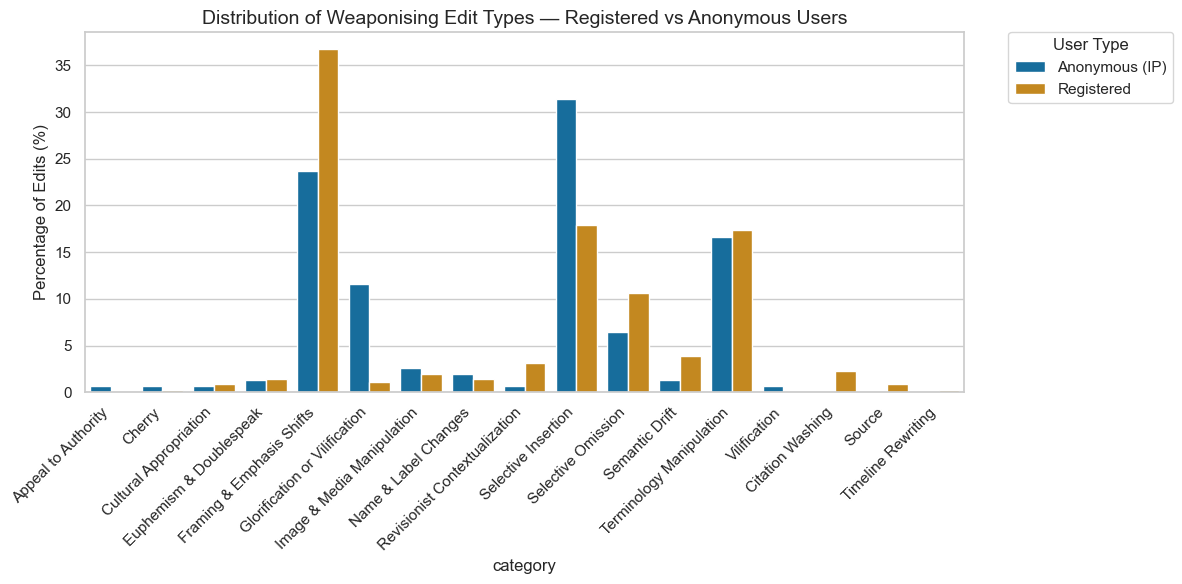

In [49]:
# Example: ensure user_type column exists (based on previous logic)
def get_user_type(row):
    if any(c.isdigit() for c in row["user"].split(".") if row["user"].count(".") == 3):
        return "Anonymous (IP)"
    else:
        return "Registered"

df["user_type"] = df.apply(get_user_type, axis=1)

# 1️⃣ Group by user_type and classification
class_counts = (
    df.groupby(["user_type", "category"])
    .size()
    .reset_index(name="count")
)

# 2️⃣ Normalize (to get proportions instead of raw counts)
total_by_type = class_counts.groupby("user_type")["count"].sum().reset_index(name="total")
class_counts = class_counts.merge(total_by_type, on="user_type")
class_counts["percentage"] = (class_counts["count"] / class_counts["total"]) * 100

# 3️⃣ Plot comparison
sns.set(style="whitegrid", palette="colorblind")

plt.figure(figsize=(12, 6))
sns.barplot(
    data=class_counts,
    x="category",
    y="percentage",
    hue="user_type"
)

plt.title("Distribution of Weaponising Edit Types — Registered vs Anonymous Users", fontsize=14)
plt.ylabel("Percentage of Edits (%)")
plt.xticks(rotation=45, ha="right")
plt.legend(
    title="User Type",
    bbox_to_anchor=(1.05, 1),  # (x, y) position of legend
    loc="upper left",          # anchor point inside legend box
    borderaxespad=0
)
plt.tight_layout()
plt.show()
